# Перемешиваем модальности

# Metadata
Dataset, form, transforms, model info, run info

In [1]:
TITLE = "int+noise+blur+cont+etc, VNet+sgdschfree+dicefocal, mom0.01"

# Imports

In [2]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets.mri_preloaded import *
from glio.specific.mri_around import *

from glio.torch_tools import ConcatZeroChannelsToDataloader, BatchInputTransforms

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Dataset

In [3]:
bratstrain = get_ds_around(BRATS2024SMALL_HIST96_TRAIN)
bratstest = get_ds_around(RHUH_HIST140_NOADC_TRAIN)

In [4]:
dstrain = DSToTarget(0)
dstest = DSToTarget(0)

from monai import transforms as mtf
gaussianblur = mtf.RandGaussianSmooth(prob=0.1) # type:ignore
biasfield = mtf.RandBiasField(prob=0.1) # type:ignore
contrast = mtf.RandAdjustContrast(gamma = (0.5, 2), prob=0.1) # type:ignore
hist_shift = mtf.RandHistogramShift(prob=0.05) # type:ignore
gibbs = mtf.RandGibbsNoise(prob=0.1) # type:ignore
kspike = mtf.RandKSpaceSpikeNoise(prob=0.1) # type:ignore
riccan = mtf.RandRicianNoise(std=0.5, prob=0.05) # type:ignore
tfms = mtf.compose.Compose([gaussianblur, biasfield, contrast, hist_shift, gibbs, kspike, riccan])
def rand_intensity_noise(g:torch.Tensor):
    if random.random() < 0.1: g = g + torch.randn_like(g) * random.triangular(0, 0.33, 0)
    if random.random() < 0.1: g += random.triangular(-1, 1, 0)
    if random.random() < 0.1: g *= random.triangular(0.5, 2, 1)
    # if random.random() < 0.5: g = tfms(g)
    return g

dstrain.add_samples(bratstrain, loader_around_seq, randcrop, [get0, GroupwiseTfms([tfms, rand_intensity_noise]), ], get1)
dstest.add_samples(bratstest, loader_around_seq, randcrop, get0, get1)
print(len(dstrain))
print(len(dstest))

16376
18742


# Inputs / targets preview

(<Figure size 2400x2400 with 4 Axes>,
 array([[<Axes: title={'center': 'inputs'}>,
         <Axes: title={'center': 'targets'}>],
        [<Axes: title={'center': 'inputs - test'}>,
         <Axes: title={'center': 'targets - test'}>]], dtype=object))

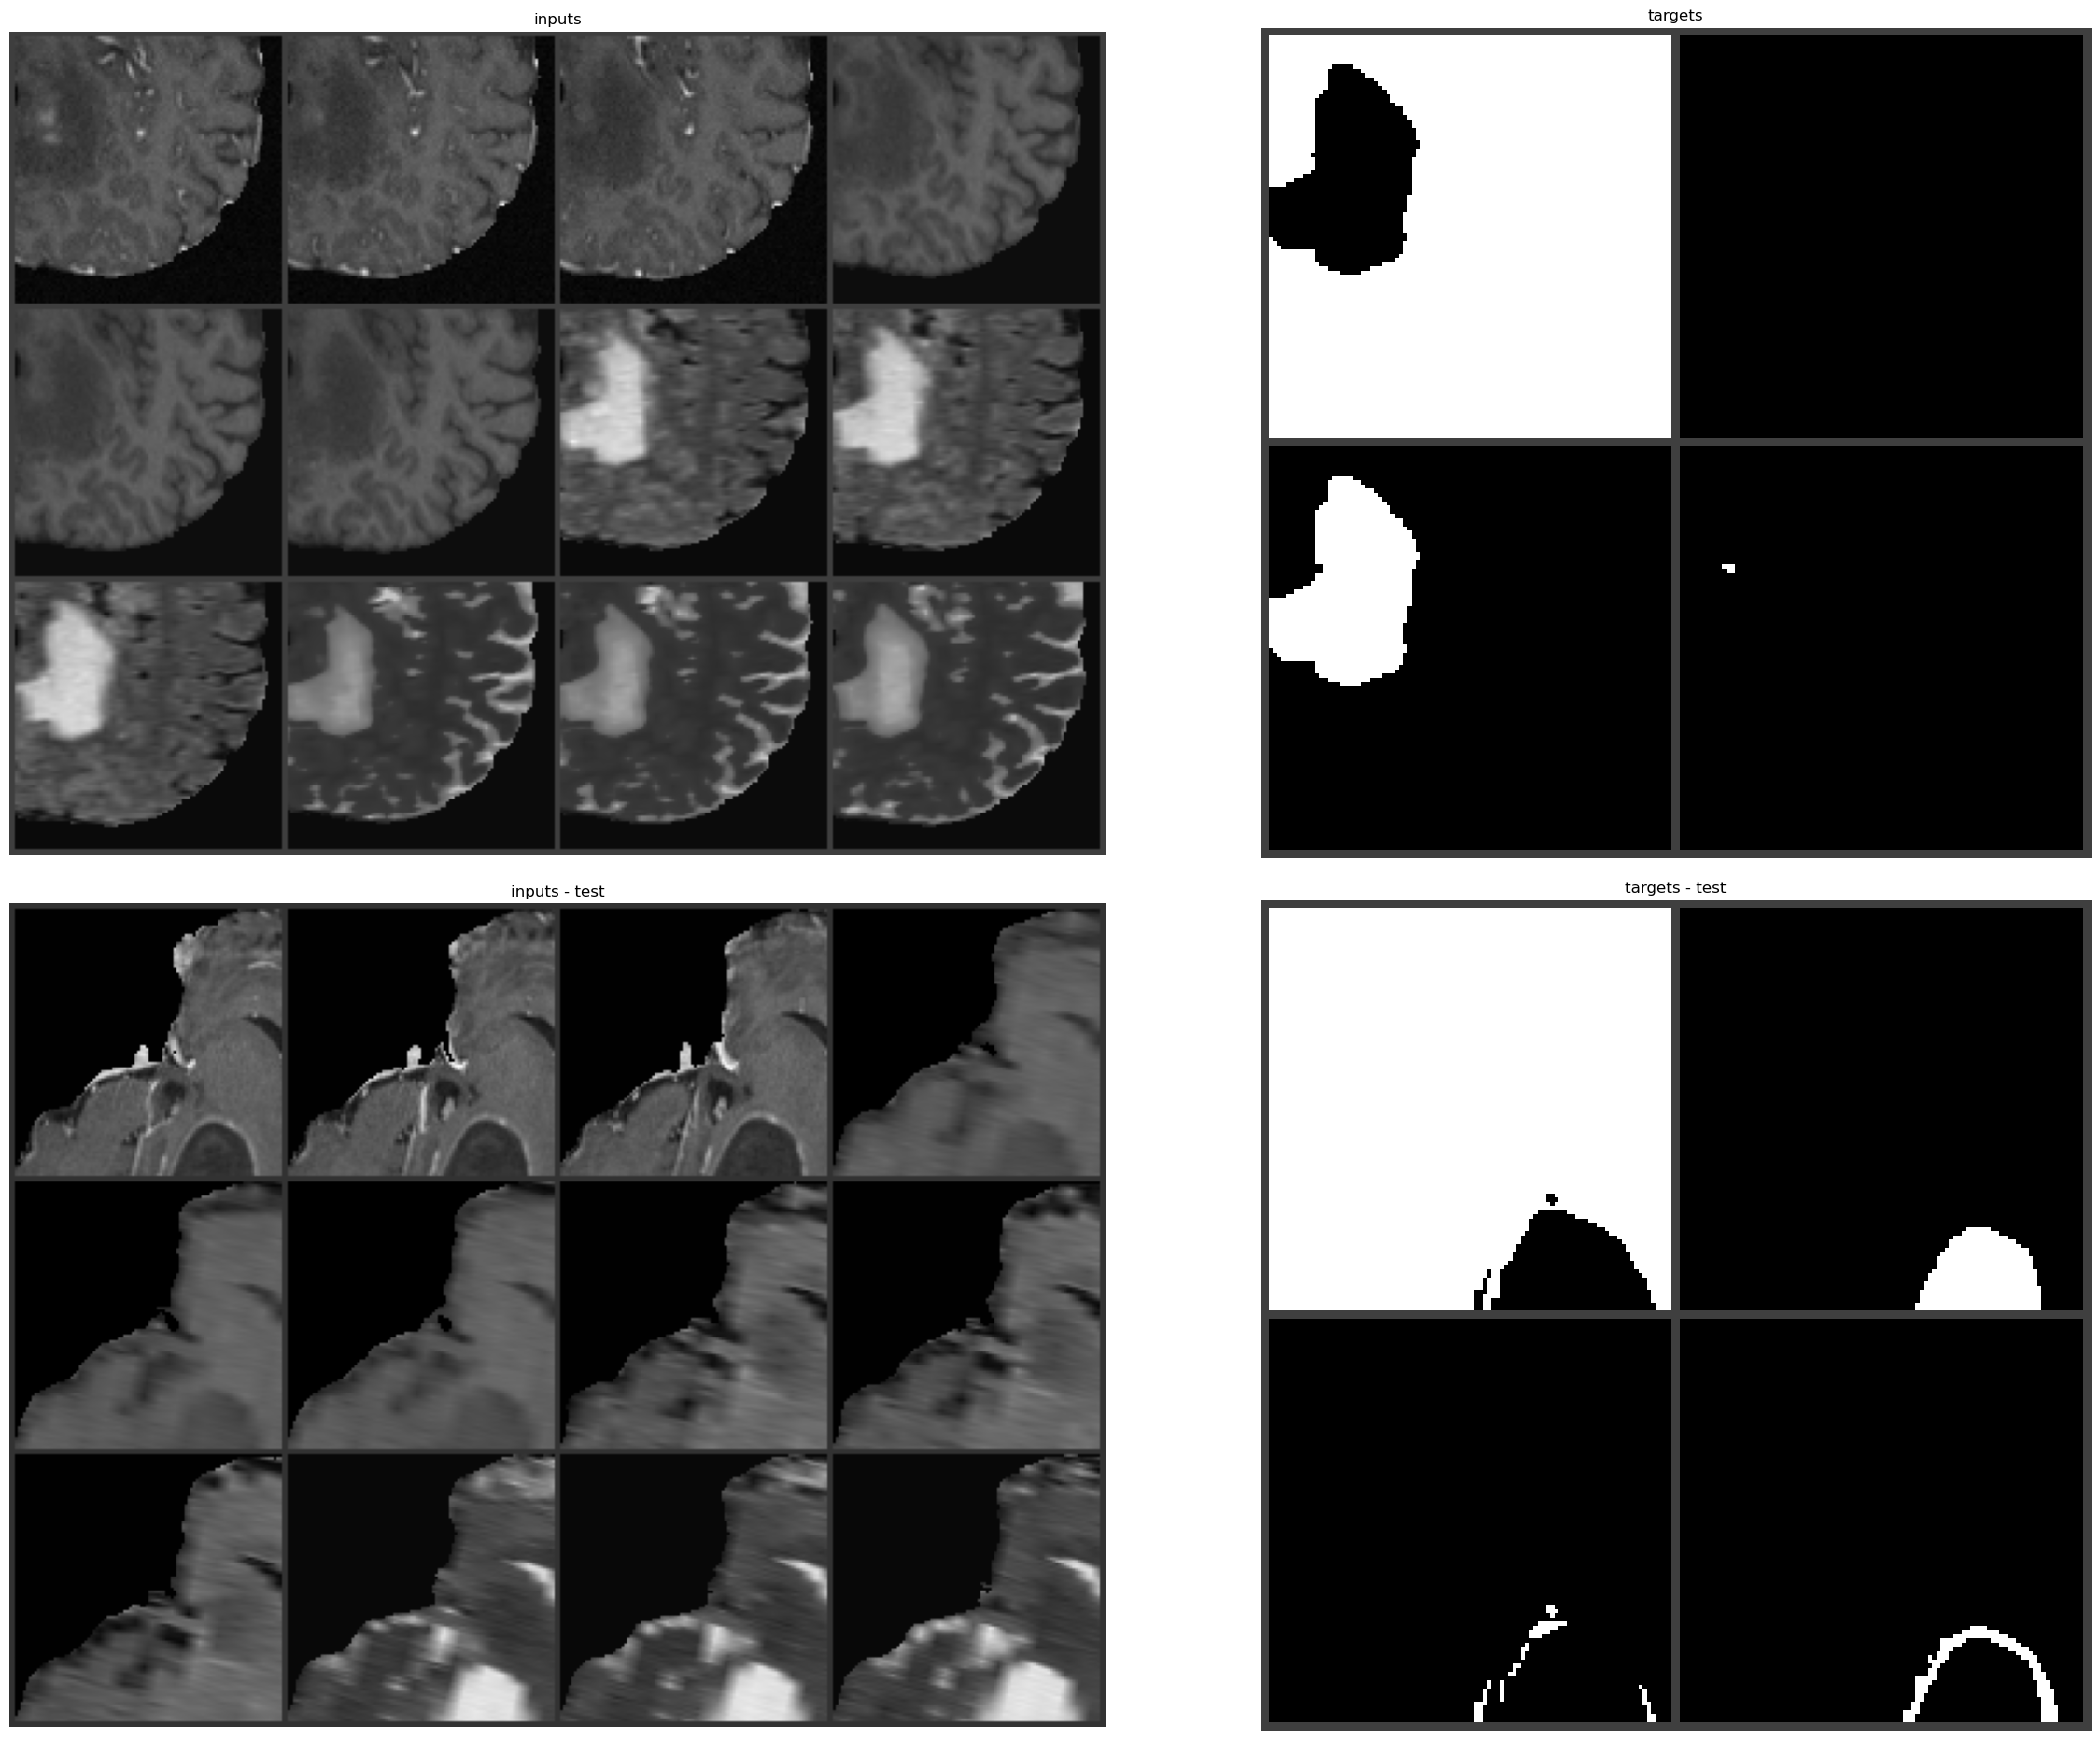

In [5]:
fig = Figure()
sample_ = dstrain[300]
fig.add().imshow_batch(sample_[0]).style_img('inputs')
fig.add().imshow_batch(sample_[1]).style_img('targets')
sample_ = dstest[20]
fig.add().imshow_batch(sample_[0]).style_img('inputs - test')
fig.add().imshow_batch(sample_[1]).style_img('targets - test')
fig.create(2, figsize=(24,24))

# Model

In [6]:
from monai.networks.nets import VNet # type:ignore
print(f"{count_parameters(VNet(2, 16, 4)) = }")

count_parameters(VNet(2, 16, 4)) = 9366348


# Train

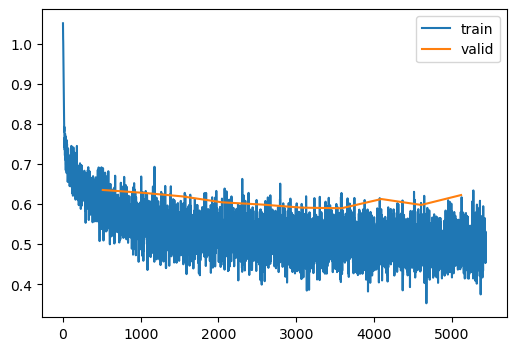

Keyboard interrupt, stopping the training...
time: min: 6.9334; max: 8148.8445; last: 8148.8445
lr: min: 10.0000; max: 10.0000; last: 10.0000
train loss: min: 0.3528; max: 1.0504; last: 0.4562
train accuracy: min: 0.3080; max: 0.9815; last: 0.9665
train iou: min: 0.2101; max: 0.9639; last: 0.9449
train precision: min: 0.3080; max: 0.9800; last: 0.9665
train recall: min: 0.3080; max: 0.9800; last: 0.9665
train f1: min: 0.3080; max: 0.9815; last: 0.9665
train average precision: min: 0.2488; max: 0.3645; last: 0.2962
train roc auc: min: 0.4565; max: 0.7261; last: 0.6214
test loss: min: 0.5896; max: 0.6351; last: 0.6225
test accuracy: min: 0.9335; max: 0.9405; last: 0.9335
test iou: min: 0.8721; max: 0.9256; last: 0.8721
test precision: min: 0.9220; max: 0.9480; last: 0.9269
test recall: min: 0.9220; max: 0.9480; last: 0.9269
test f1: min: 0.9289; max: 0.9435; last: 0.9289
test average precision: min: 0.2590; max: 0.2789; last: 0.2789
test roc auc: min: 0.5329; max: 0.5871; last: 0.5865


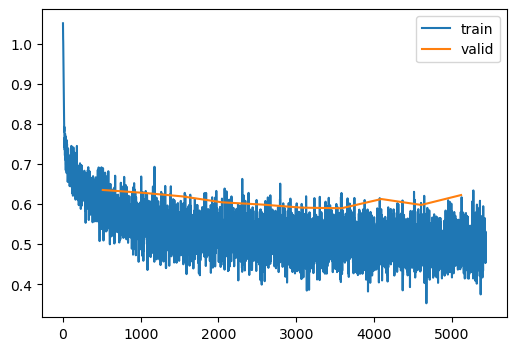

In [7]:
from schedulefree import SGDScheduleFree
from monai.losses import DiceFocalLoss # type:ignore

MODEL = VNet(2, 16, 4)
NAME = f"{MODEL.__class__.__name__}"
LR = 10
BATCH_SIZE = 32
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = ConcatZeroChannelsToDataloader(DataLoader(dstrain, BATCH_SIZE, shuffle=True), 16)
dltest = ConcatZeroChannelsToDataloader(DataLoader(dstest, BATCH_SIZE), 16)

OPT = SGDScheduleFree(MODEL.parameters(), lr=LR, warmup_steps=100, momentum=0.01)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16), Log_LastGradsAngle(128), Log_GradPath(1)
              #Log_UpdateDist(128), Log_GradDist(128), Log_GradUpdateAngle(128), Log_ParamDist(128),
              #Log_LastUpdatesAngle(128),
              #Log_ParamPath(32), Log_UpdatePath(32),
              Log_Time(), Save_Best(), Save_Last(), Log_LR(), PerformanceTweaks(True), Accelerate("no"),
              Metric_Accuracy(True, True, False, name = 'accuracy', step=4),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_Precision(4, True, True, step=16),
              Torcheval_Recall(4, True, True, step=16),
              Torcheval_Dice(4, True, True, step=8, name='f1'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              FastProgressBar(step_batch=128, plot=True),
              Summary(),
              PlotSummary(),
              CallTrainAndEvalOnOptimizer(),
              PrintLoss(),
              )

LEARNER_NAME = f"{TITLE} lr{LR:.0e}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=False, test_on_interrupt=False)

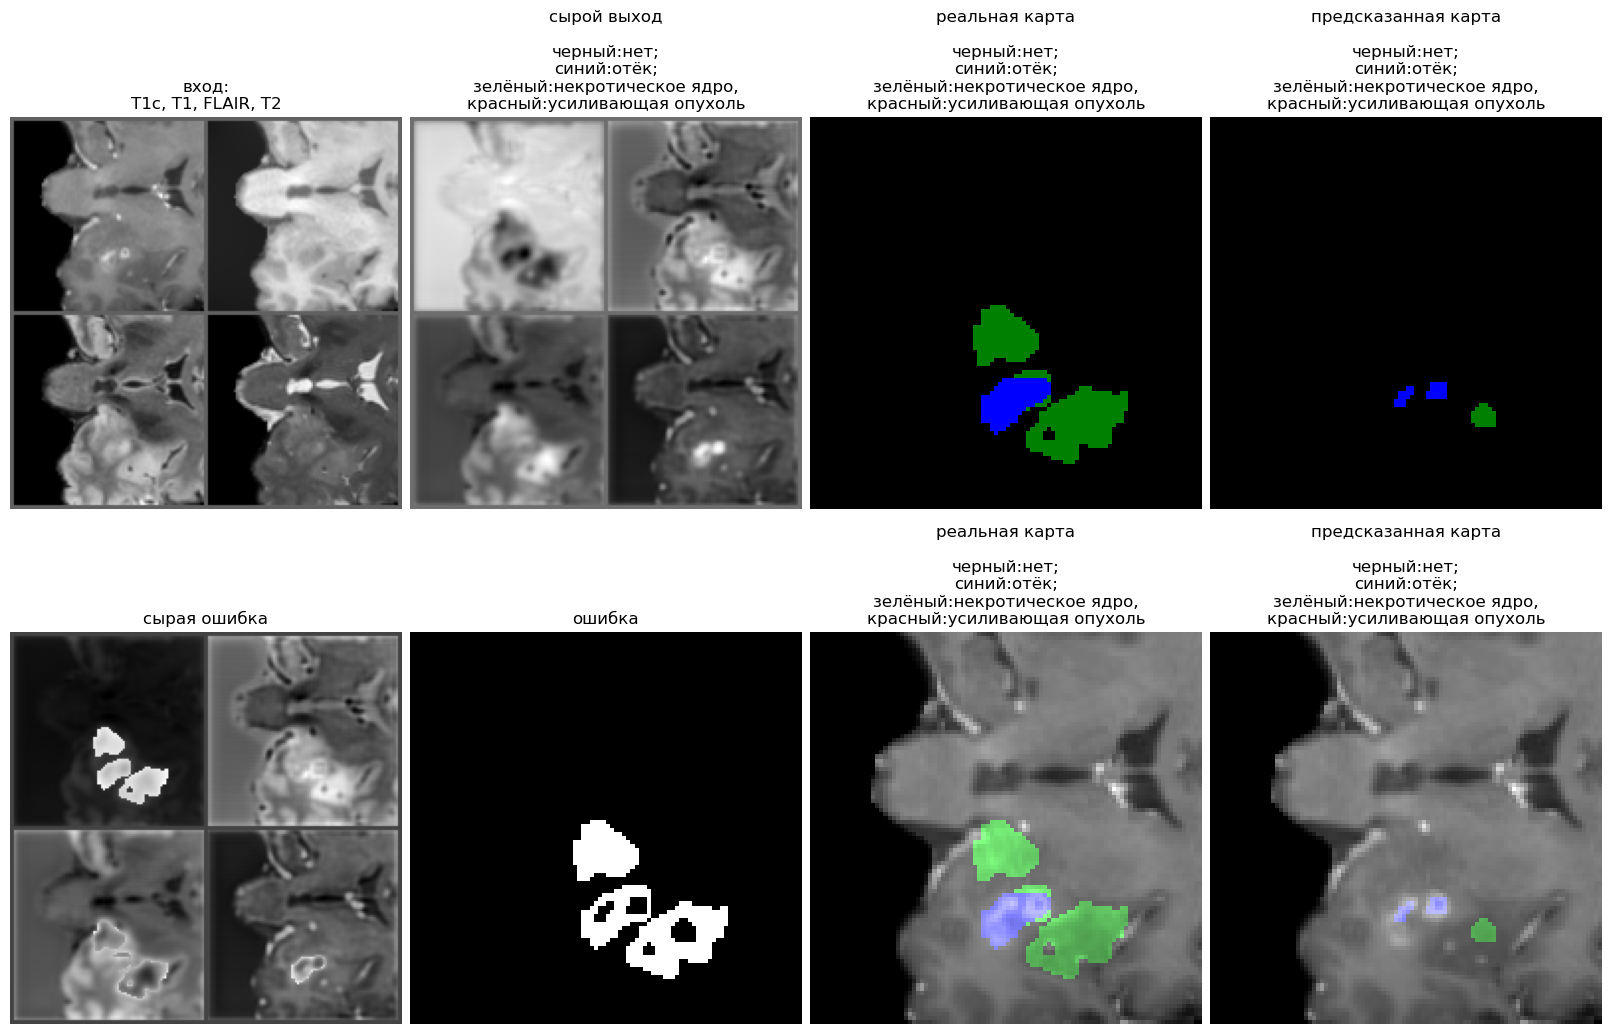

In [10]:
visualize_predictions(learner.inference, dstrain[200], expand_channels=16)

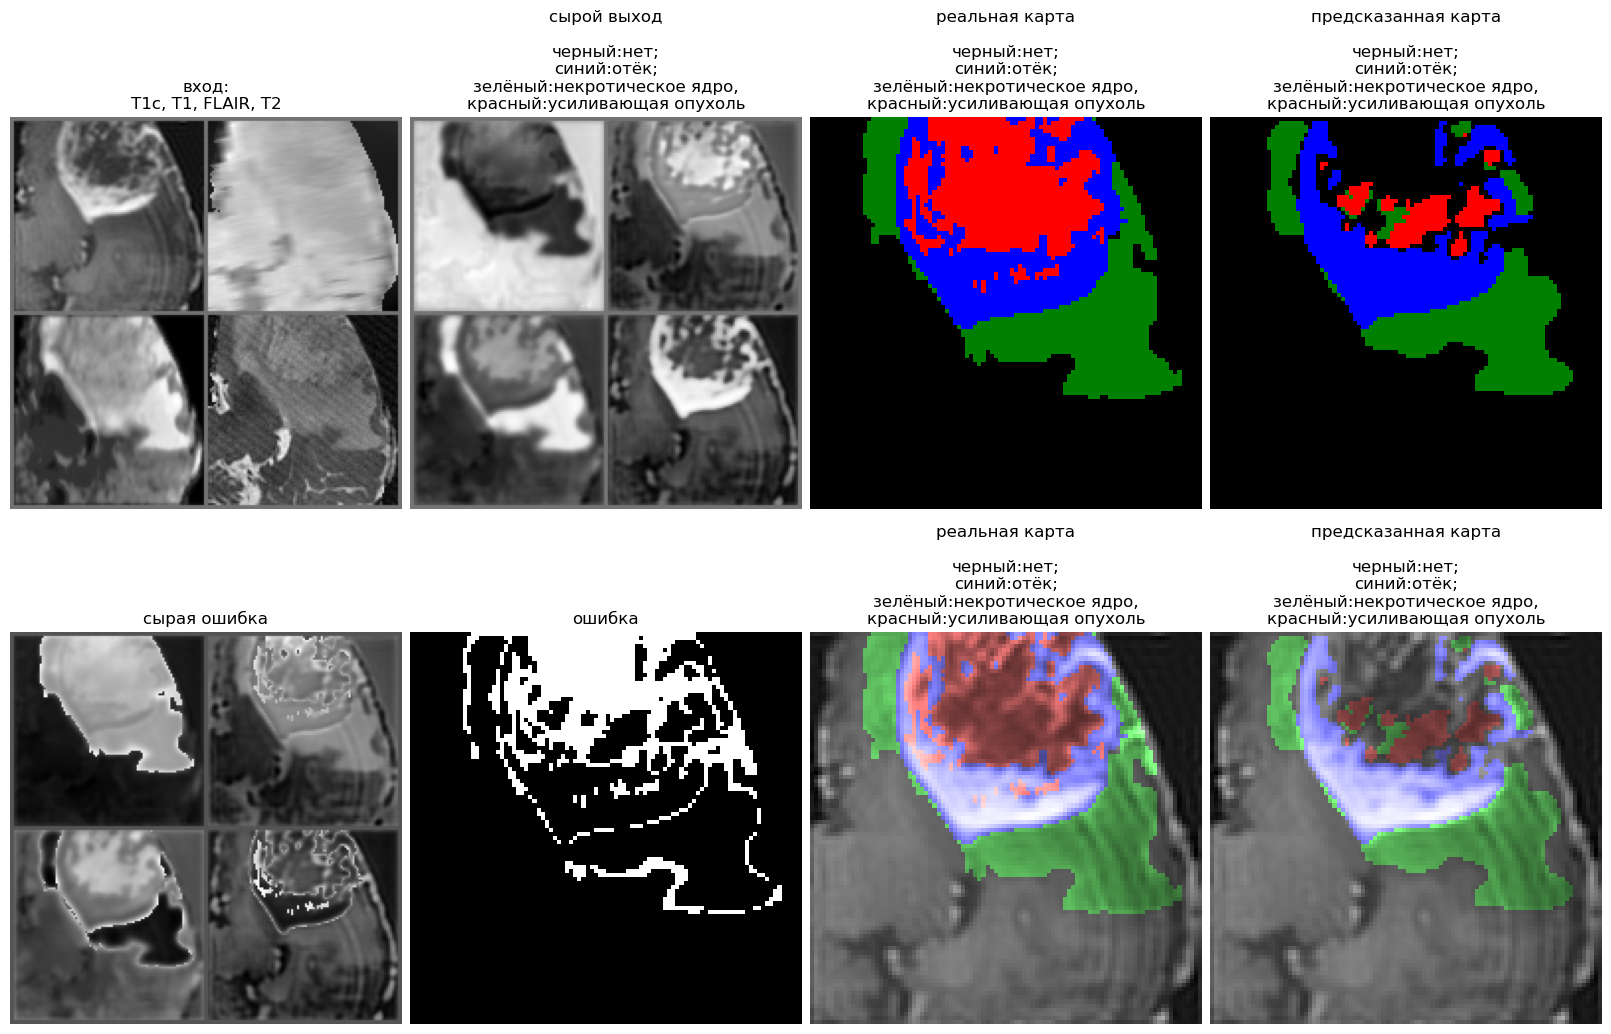

In [22]:
visualize_predictions(learner.inference, dstrain[2100], expand_channels=16)

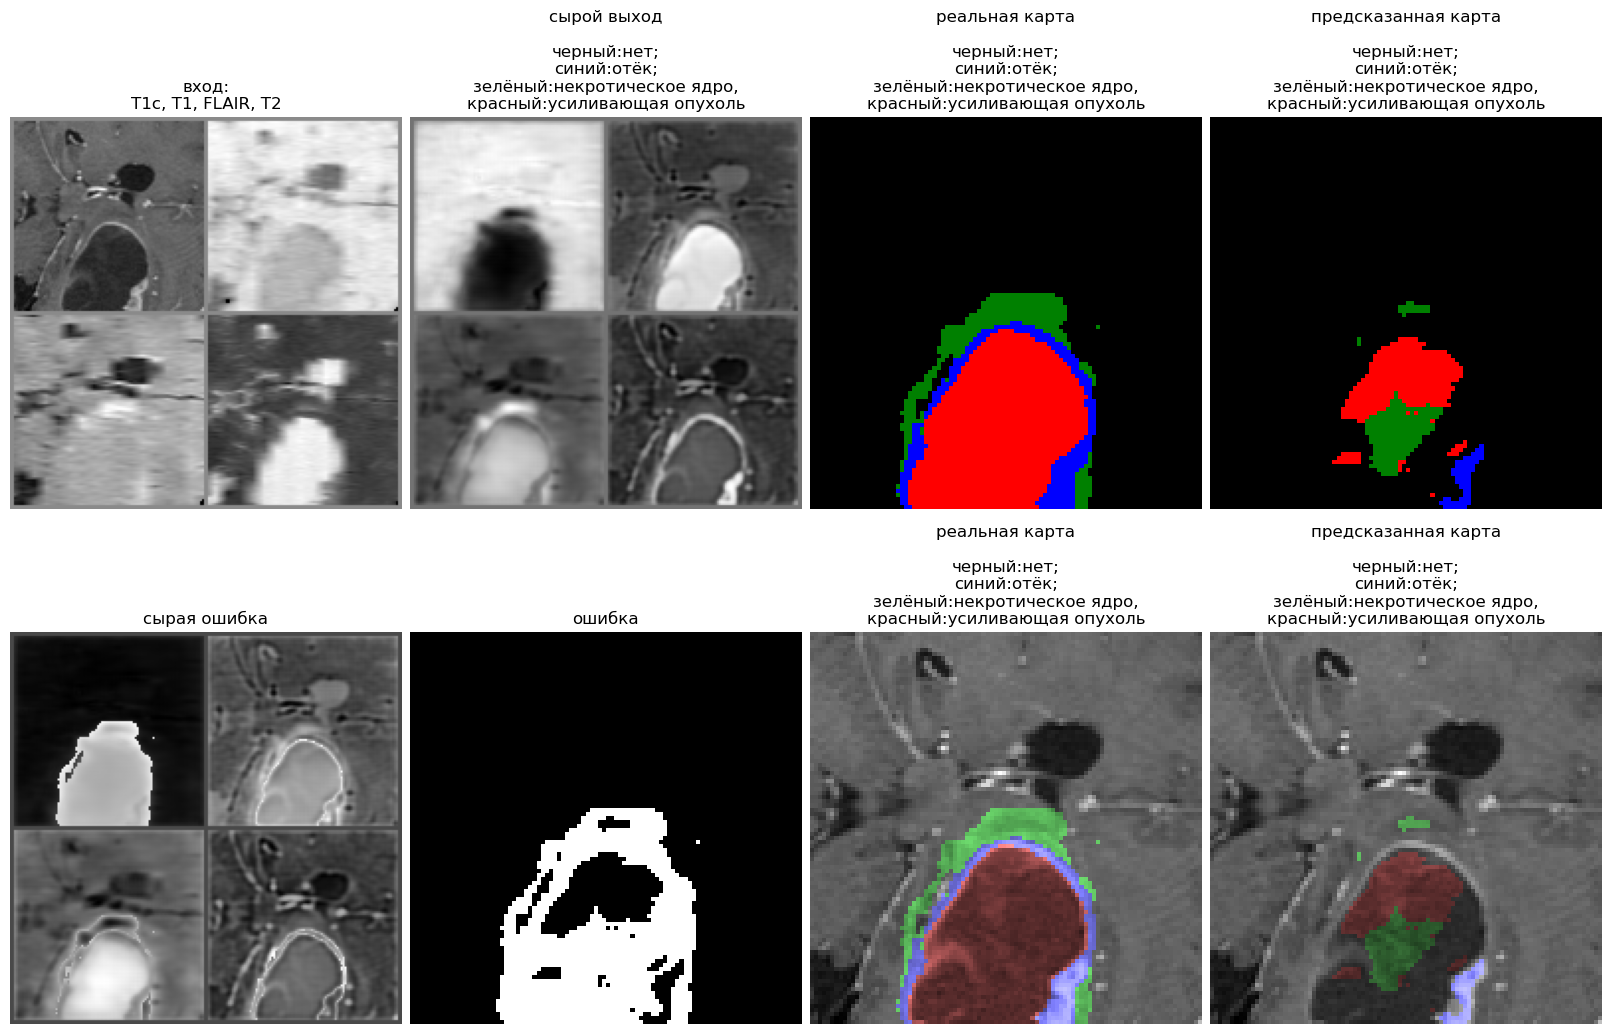

In [23]:
visualize_predictions(learner.inference, dstest[100], expand_channels=16)